# Проект: вариант 4

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

_Данные:_

    active_users – информация о пользователях, которые посещали приложение во время эксперимента.
    groups – разбивка пользователей на контрольную (А) и тестовую (В) группы.
    purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента

 ## Гипотеза.
 Новая модель оплаты коллекций шаблонов принесет больше прибыли

## Изменения в тестовой группе
В тестовой группе будем предлагать новую систему оплаты

## Метрики
- конверсия в покупку активных юзеров CR,
- средний доход на юзера ARPU
- средний доход на платящего юзера ARPPU
- средний чек


In [1]:
import numpy as np

In [2]:
from scipy.stats import chi2_contingency, mannwhitneyu

In [3]:
import seaborn as sns

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df_active_users = pd.read_csv('active_users.csv')
df_active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [8]:
df_active_users.shape

(8341, 4)

In [9]:
df_active_users['user_id'].nunique()

8341

In [10]:
df_groups = pd.read_csv('groups.csv')
df_groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [11]:
df_purchase = pd.read_csv('purchases.csv')
df_purchase.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [12]:
df_groups.shape

(74576, 2)

In [13]:
df_groups['user_id'].nunique()

74576

проверим что у нас с пользователями: все ли платившие активные и участвовали в эксперименте

In [14]:
df_purchase.shape[0] - df_purchase['user_id'].isin(df_active_users['user_id']).sum()

149

149 пользователей, совершивших покупку, не являются активными, сохраним их в отдельную выборку

In [15]:
df_users_149 = df_purchase.loc[~df_purchase['user_id'].isin(df_active_users['user_id'])]
df_users_149.shape

(149, 2)

In [16]:
df_purchase.shape[0] - df_purchase['user_id'].isin(df_groups['user_id']).sum()

0

все пользователи, которые совершили покупку, участвовали в эксперименте

In [17]:
df_active_users.shape[0] / df_groups.shape[0]

0.11184563398412357

активных пользователей всего 11% от общего числа пользователей, участвующих в A/B тесте

In [18]:
(df_purchase.shape[0] - 149) / df_active_users.shape[0]

0.046996762978060186

и только 0.5% активных совершили покупку в период эксперимента

соединим все данные по пользвателям из эксперимента в один датафрейм

In [19]:
df = df_groups.merge(df_active_users, on='user_id', how='left')
df.shape

(74576, 5)

In [20]:
df = df.merge(df_purchase, on='user_id', how='left')
df.shape

(74576, 6)

заменим отсутствующие значения в столбце revenue на 0, а в столбцах country, platform, sex на "нет данных"

In [21]:
df['revenue'].fillna(0, inplace=True)

In [22]:
df.fillna('нет данных', inplace=True)
df.head()

,user_id,group,country,platform,sex,revenue
0,9149,B,нет данных,нет данных,нет данных,0.0
1,9150,B,нет данных,нет данных,нет данных,0.0
2,9151,A,нет данных,нет данных,нет данных,0.0
3,9152,B,нет данных,нет данных,нет данных,0.0
4,9153,B,нет данных,нет данных,нет данных,0.0


In [23]:
df['group'].value_counts(normalize=True)

B    0.80298
A    0.19702
Name: group, dtype: float64

соотношение тестовой и контролькой группы 80/20

In [24]:
df_active_users = df_active_users.merge(df_groups, on='user_id')

посмотрим на качество разбиения на группы (на основе данных об активных пользователях)

группа - платформа

In [25]:
df_platform_group = df_active_users[['group', 'platform']]

In [26]:
crosst_group_platform = pd.crosstab(df_platform_group.platform, df_platform_group.group)
crosst_group_platform

group,A,B
platform,,
android,834,3787
ios,704,3016


In [27]:
value = np.array([crosst_group_platform.iloc[0].values,
                  crosst_group_platform.iloc[1].values])

In [28]:
_, p_value, _, _ = chi2_contingency(value)

In [29]:
p_value

0.31833776540573483

Поскольку значение p_value > 0,05, мы не можем опровергнуть нулевую гипотезу и предположим, что переменные не зависят друг от друга

группа - пол

In [30]:
df_sex_group = df_active_users[['group', 'sex']]

In [31]:
crosst_group_sex = pd.crosstab(df_sex_group.sex, df_sex_group.group)
crosst_group_sex

group,A,B
sex,,
female,753,3392
male,785,3411


In [32]:
value = np.array([crosst_group_sex.iloc[0].values,
                  crosst_group_sex.iloc[1].values])

In [33]:
_, p_value, _, _ = chi2_contingency(value)

In [34]:
p_value

0.5420161465061012

Поскольку значение p_value > 0,05, мы не можем опровергнуть нулевую гипотезу и предположим, что переменные не зависят друг от друга

In [35]:
df_country_group = df_active_users[['group', 'country']]

In [36]:
crosst_group_country = pd.crosstab(df_country_group.country, df_country_group.group)
crosst_group_country

group,A,B
country,,
Russia,915,4492
Sweden,623,2311


In [37]:
value = np.array([crosst_group_country.iloc[0].values,
                  crosst_group_country.iloc[1].values])

In [38]:
_, p_value, _, _ = chi2_contingency(value)

In [39]:
p_value

1.4440642250057943e-06

Поскольку значение p_value < 0,05, мы можем опровергнуть нулевую гипотезу и предположим, что переменные зависят друг от друга

по результатам анализа разбиения активных пользователей на группы, можно сделать выводы что с разбиением по полу и платформе все хорошо. а по странам есть преобладание России в группах в разных пропорциях. в тестовой группе почти в 2 раза доля России больше. возможно пользователям из России больше понравилась новая система оплаты или по какой-то технической причине произошел перекос

Такое неравномерное разбиение по странам могло повлиять на результаты эксперимента. Проверим эту гипотезу позже

посмотрим описательные статистики в группах без 0 revenue

In [40]:
users_id_149 = df_users_149['user_id'].to_list()

In [41]:
df_describe = df.query('(revenue > 0) & (user_id not in @users_id_149)')\
                .groupby(['group'])\
                .agg({'revenue': ['count', 'min', 'mean', 'median', 'max']})
df_describe

revenue                                    
        count    min         mean  median     max
group                                            
A          78  208.0   943.564103   596.0  3671.0
B         314  207.0  1267.875796  1151.0  4660.0

In [42]:
(1267 - 943) / 1267 * 100

25.57221783741121

средний чек вырос на 25%, случайный ли это результат проверим с помощью критерия манна-уитни

посмотрим на распределение revenue в группах без 149 неактивным пользователей и без 0 (т к их много и будет невидно распределение)

<AxesSubplot:xlabel='revenue', ylabel='Density'>

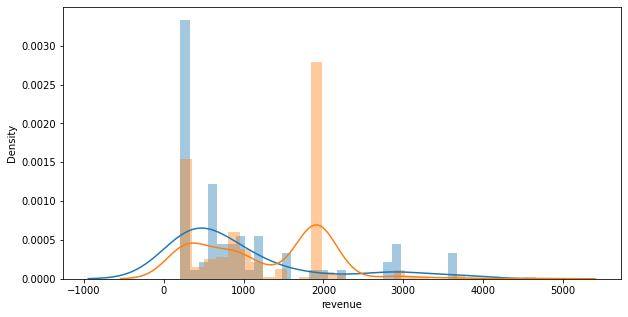

In [43]:
plt.figure(figsize=(10, 5))
sns.distplot(
    df.loc[(df['group'] == 'A') & (df['revenue'] > 0) & (~df['user_id'].isin(df_users_149['user_id']))]['revenue'],
    bins=30)
sns.distplot(
    df.loc[(df['group'] == 'B') & (df['revenue'] > 0) & (~df['user_id'].isin(df_users_149['user_id']))]['revenue'],
    bins=30)

т к праспределения в группах не нормальны, то для их сравнения используем непараметрический критерий Манна-Уитни.
За $H_0$ возьмем равенство распределений

In [44]:
mannwhitneyu(
    df.loc[(df['group'] == 'A') & (df['revenue'] > 0) & (~df['user_id'].isin(df_users_149['user_id']))]['revenue'],
    df.loc[(df['group'] == 'B') & (df['revenue'] > 0) & (~df['user_id'].isin(df_users_149['user_id']))]['revenue'])

MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

полученное значение *p_value* < 0.05, значит мы может отклонить нашу гипотезу $H_0$
следовательно, есть статистически значимые различия распределений

посмотрим на распределения по группам 149 пользователей, которые заплатили, но не оказались в списке активных

<AxesSubplot:xlabel='revenue', ylabel='Density'>

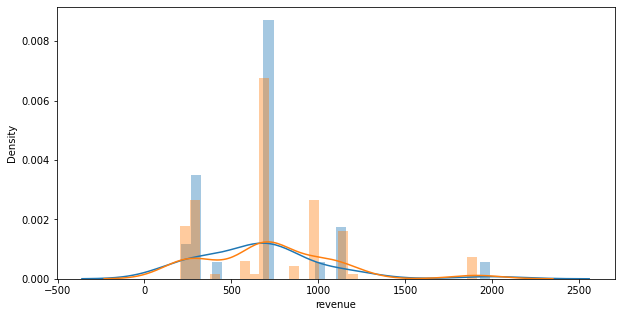

In [45]:
plt.figure(figsize=(10, 5))
sns.distplot(df.loc[(df['group'] == 'A') & (df['user_id'].isin(df_users_149['user_id']))]['revenue'],
             bins=30)
sns.distplot(df.loc[(df['group'] == 'B') & (df['user_id'].isin(df_users_149['user_id']))]['revenue'],
             bins=30)

распределения кажутся очень похожими, возможно это какие-то автоматические платежи (типа подписок)
проверим гипотезу о равенстве этих распределений по критерию манна-уитни

In [46]:
mannwhitneyu(df.loc[(df['group'] == 'B') & (df['user_id'].isin(df_users_149['user_id']))]['revenue'],
             df.loc[(df['group'] == 'A') & (df['user_id'].isin(df_users_149['user_id']))]['revenue'])

MannwhitneyuResult(statistic=1943.5, pvalue=0.32858504025883084)

p_value > 0.05, значит нет достаточных оснований отклонить гипотезу о равенстве распределений
вероятно это автоматические платежи, которые никак не зависят от эксперимента

чтобы понять какие еще метрики изменились по группам, посчитаем ARPU (средний доход на пользователя), ARPPU (средний доход на платящего пользователя)

In [47]:
# количество всех пользователей по группам
count_users_by_group = df.groupby('group', as_index=False)\
                         .agg({'user_id': 'count'})
count_users_by_group

,group,user_id
0,A,14693
1,B,59883


In [48]:
count_pay_users_by_group = df.loc[df['revenue'] > 0]\
                             .groupby('group', as_index=False)\
                             .agg({'user_id': 'count'})
count_pay_users_by_group

,group,user_id
0,A,107
1,B,434


In [49]:
sum_pay_by_group = df.groupby('group', as_index=False)\
                     .agg({'revenue': 'sum'})
sum_pay_by_group

,group,revenue
0,A,93162.0
1,B,485575.0


In [50]:
sum_pay_by_group['ARPU'] = sum_pay_by_group['revenue'] / count_users_by_group['user_id']
sum_pay_by_group['ARPPU'] = sum_pay_by_group['revenue'] / count_pay_users_by_group['user_id']
sum_pay_by_group

,group,revenue,ARPU,ARPPU
0,A,93162.0,6.340570,870.672897
1,B,485575.0,8.108729,1118.836406


In [51]:
(sum_pay_by_group.query('group == "B"').values[0][2] - sum_pay_by_group.query('group == "A"').values[0][2])\
    / (sum_pay_by_group.query('group == "B"').values[0][2]) * 100

21.80561733052256

In [52]:
(sum_pay_by_group.query('group == "B"').values[0][3] - sum_pay_by_group.query('group == "A"').values[0][3]) \
    / (sum_pay_by_group.query('group == "B"').values[0][3]) * 100

22.180499946830544

ARPU и ARPPU выросли примерно на 22% в тестовой группе

посчитаем конверсии в группах

In [53]:
df['CR'] = df['revenue'] > 0
df.head()

,user_id,group,country,platform,sex,revenue,CR
0,9149,B,нет данных,нет данных,нет данных,0.0,False
1,9150,B,нет данных,нет данных,нет данных,0.0,False
2,9151,A,нет данных,нет данных,нет данных,0.0,False
3,9152,B,нет данных,нет данных,нет данных,0.0,False
4,9153,B,нет данных,нет данных,нет данных,0.0,False


Посчитаем конверсию воронкой: все пользователи группы -> активные пользователи (и их доля от всех пользователей) -> платящие пользователи (и их доля от активных пользователей)
А наличие разницы в конверсиях по группам оценим статистически по хи-квадртат Пирсона.

In [58]:
df['CR_active'] = df['country'] != 'нет данных'
df.head()

,user_id,group,country,platform,sex,revenue,CR,CR_active
0,9149,B,нет данных,нет данных,нет данных,0.0,False,False
1,9150,B,нет данных,нет данных,нет данных,0.0,False,False
2,9151,A,нет данных,нет данных,нет данных,0.0,False,False
3,9152,B,нет данных,нет данных,нет данных,0.0,False,False
4,9153,B,нет данных,нет данных,нет данных,0.0,False,False


In [59]:
df['all_users'] = True
df.head()

,user_id,group,country,platform,sex,revenue,CR,CR_active,all_users
0,9149,B,нет данных,нет данных,нет данных,0.0,False,False,True
1,9150,B,нет данных,нет данных,нет данных,0.0,False,False,True
2,9151,A,нет данных,нет данных,нет данных,0.0,False,False,True
3,9152,B,нет данных,нет данных,нет данных,0.0,False,False,True
4,9153,B,нет данных,нет данных,нет данных,0.0,False,False,True


In [61]:
df_CR = df.groupby('group', as_index=False)\
          .agg({'all_users': 'sum',
                'CR_active': 'sum',
                'CR': 'sum'})
df_CR

,group,all_users,CR_active,CR
0,A,14693,1538,107
1,B,59883,6803,434


In [65]:
df_CR['CR_active_relative'] = df_CR['CR_active'] / df_CR['all_users'] * 100
df_CR['CR_relative'] = df_CR['CR'] / df_CR['CR_active'] * 100
df_CR[['group', 'all_users', 'CR_active', 'CR_active_relative', 'CR', 'CR_relative']]

,group,all_users,CR_active,CR_active_relative,CR,CR_relative
0,A,14693,1538,10.467570,107,6.957087
1,B,59883,6803,11.360486,434,6.379538


кажется, что конверсия в группах несильно изменилась, проверим эту гипотезу с помощью критерия хи-квадрат Пирсона

In [66]:
df_CR_group = df[['group', 'CR']]

In [67]:
crosst_group_CR = pd.crosstab(df_CR_group.CR, df_CR_group.group)
crosst_group_CR

group,A,B
CR,,
False,14586,59449
True,107,434


In [68]:
value = np.array([crosst_group_CR.iloc[0].values,
                  crosst_group_CR.iloc[1].values])

In [69]:
_, p_value, _, _ = chi2_contingency(value)

In [70]:
p_value

1.0

Поскольку значение p_value > 0,05, мы не можем опровергнуть нулевую гипотезу и приминаем различия в конверсии статисчитчески незначимыми

Т к выше обнаружено, что разбиение на группы по странам неравномерное, то сравним отдельно распределения по странам в группах

In [71]:
df_A_Russian = df.loc[(df['group'] == 'A')
                      & (df['revenue'] > 0)
                      & (~df['user_id'].isin(df_users_149['user_id']))
                      & (df['country'] == 'Russia')]['revenue']
df_A_Sweden = df.loc[(df['group'] == 'A')
                     & (df['revenue'] > 0)
                     & (~df['user_id'].isin(df_users_149['user_id']))
                     & (df['country'] == 'Sweden')]['revenue']

In [72]:
df_B_Russian = df.loc[(df['group'] == 'B')
                      & (df['revenue'] > 0)
                      & (~df['user_id'].isin(df_users_149['user_id']))
                      & (df['country'] == 'Russia')]['revenue']
df_B_Sweden = df.loc[(df['group'] == 'B')
                     & (df['revenue'] > 0)
                     & (~df['user_id'].isin(df_users_149['user_id']))
                     & (df['country'] == 'Sweden')]['revenue']

Text(0.5, 1.0, 'A-B Russia')

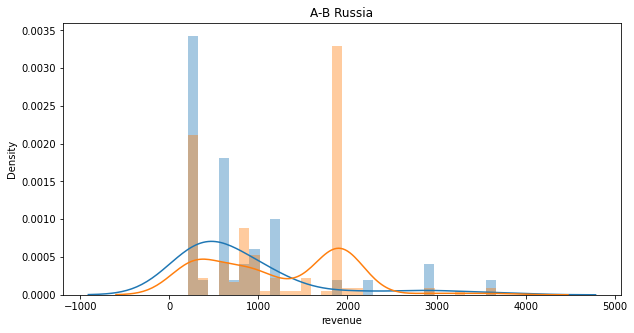

In [77]:
plt.figure(figsize=(10, 5))
sns.distplot(
    df_A_Russian,
    bins=30)
sns.distplot(
    df_B_Russian,
    bins=30)
plt.title('A-B Russia')

Text(0.5, 1.0, 'A-B Sweden')

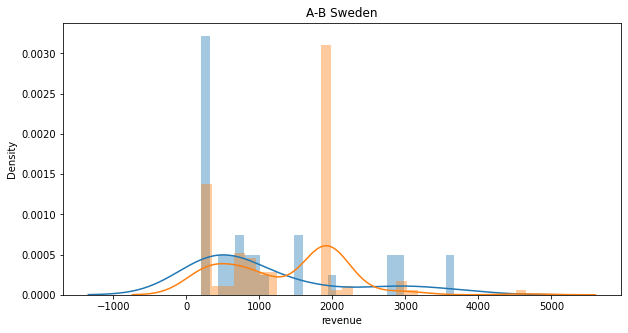

In [78]:
plt.figure(figsize=(10, 5))
sns.distplot(
    df_A_Sweden,
    bins=30)
sns.distplot(
    df_B_Sweden,
    bins=30)
plt.title('A-B Sweden')

Проверим по Манна-Уитни является ли разница распределений юзеров из России статзначима

In [79]:
mannwhitneyu(
    df_A_Russian,
    df_B_Russian)

MannwhitneyuResult(statistic=2925.5, pvalue=0.0014699816493472517)

полученное значение *p_value* < 0.05, значит мы может отклонить нашу гипотезу $H_0$
следовательно, есть статистически значимые различия распределений

Проверим по Манна-Уитни является ли разница распределений юзеров из Швеции статзначима

In [74]:
mannwhitneyu(
    df_A_Sweden,
    df_B_Sweden)

MannwhitneyuResult(statistic=1577.5, pvalue=0.03958280081671394)

полученное значение *p_value* < 0.05, значит мы может отклонить нашу гипотезу $H_0$
следовательно, есть статистически значимые различия распределений

# Выводы
стоит выкатывать изменение!
- средний чек увеличился на 25%
- ARPU и ARPPU выросли примерно на 22%

### Задание 2
Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

для 2го задания данных маловато. т к с точки зрения вовлеченности пользователей важно видеть DAU, MAU, retention, churn rate, длительность сессий и интервалы между, LTV

In [243]:
# сохраним данные в файл для проектирования дашборда
df.to_csv('data_dash.csv', sep=';', index=False)

https://public.tableau.com/app/profile/svetlana6055/viz/Dash_final_project_16498359580140/Dashboard1?publish=yes